In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Study/DL main project

/content/drive/MyDrive/Study/DL main project


# Visualize data

In [ ]:
# def get_img_position_vector(img,chanels):
#     X = None
    
#     #### YOUR CODE HERE ####
#     # X_x = np.array([np.arange(img.shape[0]) for i in range(img.shape[1])])
#     # X_y = np.array([np.arange(img.shape[1]) for i in range(img.shape[0])]).T
#     # X = np.hstack([img.reshape((-1,3)),X_x.reshape((-1,1)),X_y.reshape((-1,1))])
#     #Code mẫu
#     X = img.reshape(-1,chanels)
#     x_inds = np.arange(img.shape[0])
#     y_inds = np.arange(img.shape[1])
#     X_pos = np.stack(np.meshgrid(x_inds,y_inds)).T
#     X_pos = X_pos.reshape(-1,2)    
#     X = np.concatenate((X,X_pos),axis=1)
#     #### END YOUR CODE #####
    
#     return X

In [ ]:
# path = './train/lung/14/001/0d713a8274dc92be9a75639d9b6558e1.png'
# img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
# img = 255 - cv2.resize(img,(512,512))
# img_flatten = get_img_position_vector(img,1)
# z = img_flatten[:,1:3]
# x = img_flatten[:,0:2]
# y = img_flatten[:,[0,2]]
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.view_init(80, -60)
# ax.scatter3D(img_flatten[:,1], img_flatten[:,2], img_flatten[:,0], c=img_flatten[:,0], cmap='Greens')

# **IMPORT LIBRARIES**

In [ ]:
import os

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from process_data_v2 import ProcessData
from tqdm.auto import tqdm

In [ ]:
from keras.models import load_model

# **Load Data**

In [ ]:
csv_path = './csv'
img_load_dir = './train/png'
lung_load_dir = './train/lung'
mask_load_dir = './train/mask'

# make process variable
pdata = ProcessData(seed=42)

## Class 14

In [ ]:
class_name ='14'
batch_names =['001']
nb_batch = len(batch_names)
class_csv_path = [os.path.join(csv_path,class_name,batch_name+'.csv') for batch_name in batch_names]
class_img_load_dir = [os.path.join(img_load_dir,class_name,batch_name) for batch_name in batch_names]
class_mask_load_dir = [os.path.join(mask_load_dir,class_name,batch_name) for batch_name in batch_names]

In [ ]:
masks =[]
imgs = []
mask_size = None
for i in range(nb_batch):  
  img_names = pdata.get_img_names(class_csv_path[i])
  mask_size, tp_masks = pdata.get_masks(img_names,class_mask_load_dir[i])
  mask_size = mask_size
  tp_imgs = pdata.get_imgs(img_names,class_img_load_dir[i],size=mask_size)
  masks.extend(tp_masks)
  imgs.extend(tp_imgs)

In [ ]:
masks = np.array(masks)
imgs = np.array(imgs)

In [ ]:
from process_data_v2 import ProcessData as PD
pcd = PD(42)

In [ ]:
data = pcd.get_data(imgs,masks)
data_noise_drop = pcd.get_data_noise(data,masks,ntype=1,my_seed=42)
data_noise_snow = pcd.get_data_noise(data,masks,ntype=2,my_seed=42)[:,:,:,:1]

In [ ]:
data_noise_drop.shape

In [ ]:
plt.imshow(data_noise_drop[0,:,:,0],cmap='gray')

In [ ]:
plt.imshow(data_noise_snow[0],cmap='gray')

# **Load lung and mask**

In [ ]:
class_name ='14'
batch_name ='001'

class_csv_path = os.path.join(csv_path,class_name,batch_name+'.csv')
class_lung_load_dir = os.path.join(lung_load_dir,class_name,batch_name)
class_mask_load_dir = os.path.join(mask_load_dir,class_name,batch_name)

img_names = pdata.get_img_names(class_csv_path)
mask_size, masks = pdata.get_masks(img_names,class_mask_load_dir, size=(112,112))
lungs = pdata.get_imgs(img_names,class_lung_load_dir,size=mask_size)

In [ ]:
def duplicate_data(data,size):
  temp = np.vstack([data,data])  
  for i in range(size):
    temp = np.vstack([temp,data])
  return temp

In [ ]:
lungs = duplicate_data(lungs,10)
masks = duplicate_data(masks,10)
lungs.shape, masks.shape

((1800, 112, 112, 1), (1800, 112, 112, 1))

# **Process Data**

## **Model**

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

### **Model 1**

In [ ]:
# https://www.pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/
def dae_build(inputShape, activation='sigmoid',filters=(32, 64), latentDim=256):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		(height, width, depth) = inputShape
		chanDim = -1
		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

    # loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")
  
    # start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation(activation)(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

### **Model 2**

In [ ]:
def dae_build(width, height, depth):
  # initialize the input shape to be "channels last" along with
  # the channels dimension itself
  # channels dimension itself
  inputShape = (height, width, depth)		
  inputs = Input(shape=inputShape)
  x = inputs
  x = Conv2D(64,kernel_size=(3,3),padding='same',activation='relu')(x)
  x = MaxPool2D((2,2),strides=2)(x)
  x = Conv2D(64,kernel_size=(3,3),padding='same',activation='relu')(x)
  x = MaxPool2D((2,2),strides=2)(x)

  x = Conv2D(64,kernel_size=(3,3),padding='same',activation='relu')(x)
  x = UpSampling2D((2,2))(x)
  x = Conv2D(64,kernel_size=(3,3),padding='same',activation='relu')(x)
  x = UpSampling2D((2,2))(x)

  x = Conv2D(1,kernel_size=(3,3),padding='same',activation='sigmoid')(x)
  autoencoder = Model(inputs, x, name="autoencoder")
  # return a 3-tuple of the encoder, decoder, and autoencoder
  return autoencoder

## type 01: Dropout noise

### View

In [ ]:
data_noise_drop = pdata.get_data_noise(lungs,masks,ntype=1).astype(np.uint8)
data_noise_drop.shape

(1800, 112, 112, 1)

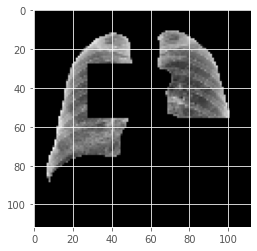

In [ ]:
plt.imshow(data_noise_drop[0,:,:,0],cmap='gray')

### Build

In [ ]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(data_noise_drop,lungs,test_size=0.25,random_state=42)

Epoch 1/100
270/270 [==============================] - 4s 13ms/step - loss: 2152.0432 - val_loss: 754.4210
Epoch 2/100
270/270 [==============================] - 3s 12ms/step - loss: 656.3695 - val_loss: 557.6857
Epoch 3/100
270/270 [==============================] - 3s 13ms/step - loss: 467.2178 - val_loss: 435.5172
Epoch 4/100
270/270 [==============================] - 3s 12ms/step - loss: 325.9270 - val_loss: 365.7451
Epoch 5/100
270/270 [==============================] - 3s 12ms/step - loss: 237.3126 - val_loss: 226.3736
Epoch 6/100
270/270 [==============================] - 3s 12ms/step - loss: 171.2325 - val_loss: 173.2432
Epoch 7/100
270/270 [==============================] - 3s 12ms/step - loss: 122.0045 - val_loss: 150.4706
Epoch 8/100
270/270 [==============================] - 3s 12ms/step - loss: 95.0268 - val_loss: 120.8542
Epoch 9/100
270/270 [==============================] - 3s 12ms/step - loss: 76.8861 - val_loss: 107.2990
Epoch 10/100
270/270 [=========================

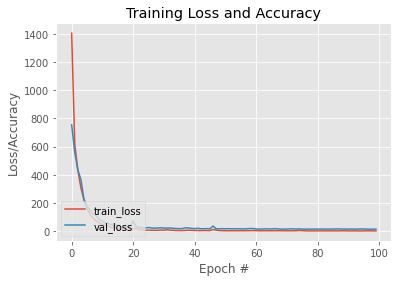

In [ ]:
EPOCHS = 100
BS = 5
(encoder, decoder, autoencoder) = dae_build(data[0].shape,activation='relu')
# autoencoder = dae_build(data[0].shape[0],data[0].shape[1],data[0].shape[2])
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	xtrain, ytrain,
	validation_data=(xtest, ytest),
	epochs=EPOCHS,
	batch_size=BS)
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
autoencoder.save('./model/model_01_relu_e100_type_01.h5')

### Kiểm thử dữ liệu train

In [ ]:
test = autoencoder.predict(data_noise_drop[:10])

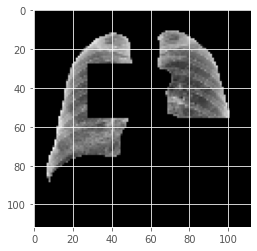

In [ ]:
plt.imshow(data_noise_drop[0,:,:,0],cmap='gray')

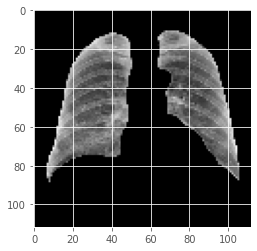

In [ ]:
plt.imshow(test[0,:,:,0],cmap='gray')

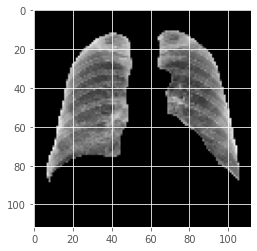

In [ ]:
plt.imshow(data[0,:,:,0],cmap='gray')

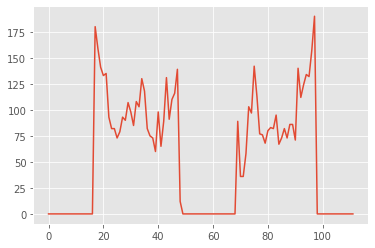

In [ ]:
plt.plot(np.arange(0,112),data[0,40,:,0])

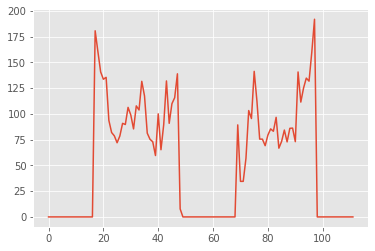

In [ ]:
plt.plot(np.arange(0,112),test[0,40,:,0])

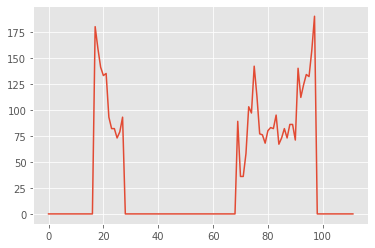

In [ ]:
plt.plot(np.arange(0,112),data_noise_drop[0,40,:,0])

### Kiểm thử trên dữ liệu mới

In [ ]:
class_name ='14'
batch_name ='000'

class_csv_path = os.path.join(csv_path,class_name,batch_name+'.csv')
class_lung_load_dir = os.path.join(lung_load_dir,class_name,batch_name)
class_mask_load_dir = os.path.join(mask_load_dir,class_name,batch_name)

img_names = pdata.get_img_names(class_csv_path)
mask_size, masks = pdata.get_masks(img_names,class_mask_load_dir, size=(112,112))
lungs = pdata.get_imgs(img_names,class_lung_load_dir,size=mask_size)

In [ ]:
data_noise_drop = pdata.get_data_noise(lungs,masks,ntype=1).astype(np.uint8)
data_noise_drop.shape

(96, 112, 112, 1)

In [ ]:
test = autoencoder.predict(data_noise_drop)

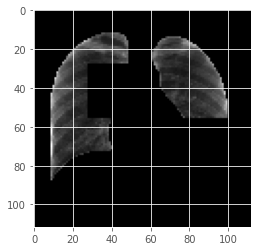

In [ ]:
plt.imshow(data_noise_drop[0,:,:,0],cmap='gray')

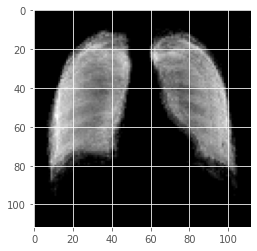

In [ ]:
plt.imshow(test[0,:,:,0],cmap='gray')

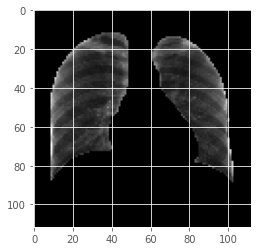

In [ ]:
plt.imshow(lungs[0,:,:,0],cmap='gray')

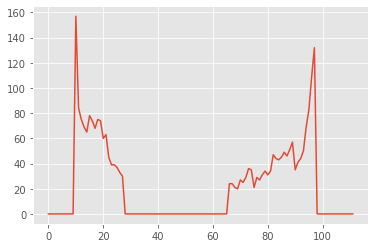

In [ ]:
plt.plot(np.arange(0,112),data_noise_drop[0,40,:,0])

In [ ]:
test[0,40,:,0].max()

154.06224

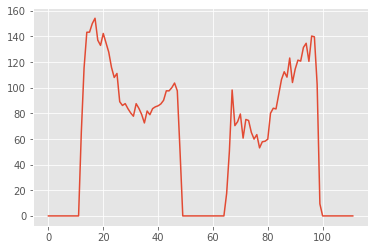

In [ ]:
plt.plot(np.arange(0,112),test[0,40,:,0])

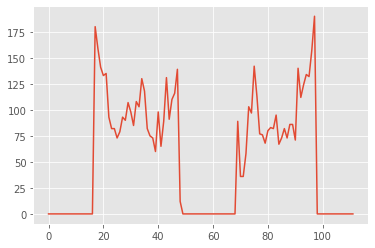

In [ ]:
plt.plot(np.arange(0,112),data[0,40,:,0])

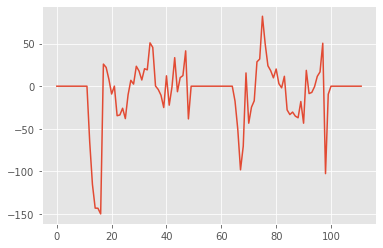

In [ ]:
plt.plot(np.arange(0,112),data[0,40,:,0]-test[0,40,:,0])

## Type 02: Snow noise

### **View**

In [ ]:
data_noise_snow = pdata.get_data_noise(lungs,masks,ntype=2)[:,:,:,:1].astype(np.uint8)
# data_noise_drop.shape, 
data_noise_snow.shape

(1800, 112, 112, 1)

In [ ]:
data = lungs
data.max(), data_noise_snow.max()

(255, 255)

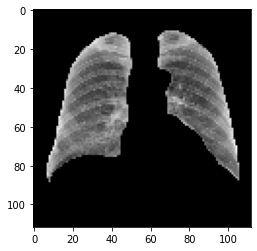

In [ ]:
plt.imshow(data[0,:,:,0],cmap='gray')

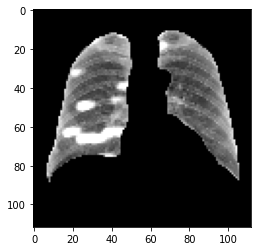

In [ ]:
plt.imshow(data_noise_snow[0,:,:,0],cmap='gray')

### **Build model**

In [ ]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(data_noise_snow,lungs,test_size=0.25,random_state=42)

Epoch 1/100
270/270 [==============================] - 4s 13ms/step - loss: 2160.6444 - val_loss: 696.9969
Epoch 2/100
270/270 [==============================] - 3s 12ms/step - loss: 578.6020 - val_loss: 467.9125
Epoch 3/100
270/270 [==============================] - 3s 12ms/step - loss: 393.3158 - val_loss: 288.0270
Epoch 4/100
270/270 [==============================] - 3s 12ms/step - loss: 265.0352 - val_loss: 276.9096
Epoch 5/100
270/270 [==============================] - 3s 12ms/step - loss: 198.0122 - val_loss: 162.8391
Epoch 6/100
270/270 [==============================] - 3s 12ms/step - loss: 134.6935 - val_loss: 117.3713
Epoch 7/100
270/270 [==============================] - 3s 12ms/step - loss: 115.3320 - val_loss: 95.4705
Epoch 8/100
270/270 [==============================] - 3s 12ms/step - loss: 78.4877 - val_loss: 66.4697
Epoch 9/100
270/270 [==============================] - 3s 12ms/step - loss: 62.5791 - val_loss: 63.4633
Epoch 10/100
270/270 [============================

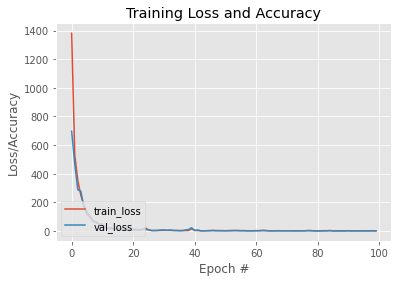

In [ ]:
EPOCHS = 100
BS = 5
(encoder, decoder, autoencoder) = dae_build(data[0].shape,activation='relu')
# autoencoder = dae_build(data[0].shape[0],data[0].shape[1],data[0].shape[2])
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	xtrain, ytrain,
	validation_data=(xtest, ytest),
	epochs=EPOCHS,
	batch_size=BS)
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
autoencoder.save('./model/model_01_relu_e100_type_02.h5')

### **View resualt**

In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 256)               12864512  
_________________________________________________________________
decoder (Functional)         (None, 112, 112, 1)       12951297  
Total params: 25,815,809
Trainable params: 25,815,425
Non-trainable params: 384
_________________________________________________________________


In [ ]:
test = autoencoder.predict(data_noise_snow[:10])

In [ ]:
abnormal = data_noise_snow[:10]-test

In [ ]:
test.max()

257.60748

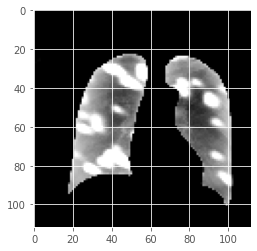

In [ ]:
plt.imshow(data_noise_snow[3, :,:,0],cmap='gray')

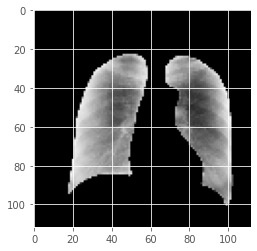

In [ ]:
plt.imshow(test[3, :,:,0],cmap='gray')

In [ ]:
amax = abnormal[3,:,:,0].max()
amin = abnormal[3,:,:,0].min()
amax, amin, amax-amin

(204.95927, -56.93463, 261.89392)

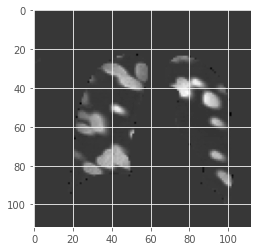

In [ ]:
plt.imshow(abnormal[3,:,:,0],cmap='gray')

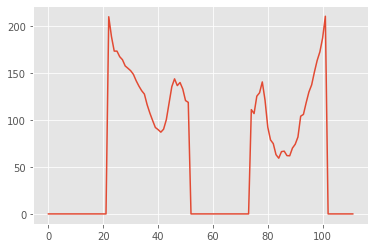

In [ ]:
plt.plot(np.arange(0,112),test[3,60,:,0])

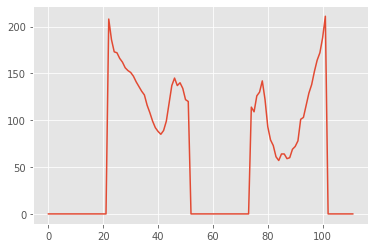

In [ ]:
plt.plot(np.arange(0,112),data[3,60,:,0])

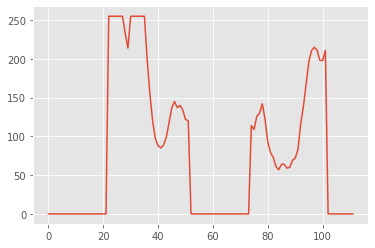

In [ ]:
plt.plot(np.arange(0,112),data_noise_snow[3,60,:,0])

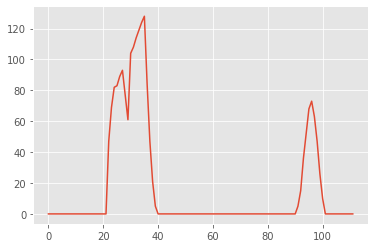

In [ ]:
plt.plot(np.arange(0,112),data_noise_snow[3,60,:,0]-data[3,60,:,0])

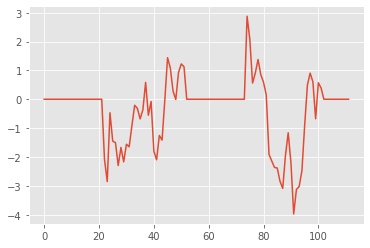

In [ ]:
plt.plot(np.arange(0,112),data[3,60,:,0]-test[3,60,:,0])

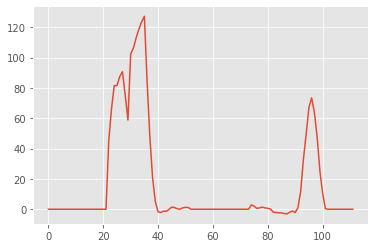

In [ ]:
plt.plot(np.arange(0,112),data_noise_snow[3,60,:,0]-test[3,60,:,0])

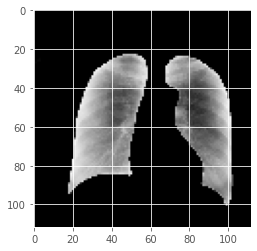

In [ ]:
plt.imshow(lungs[3, :,:,0],cmap='gray')

# **Load old model**

## import lib

In [ ]:
from keras.models import load_model

## Model 01 chạy relu epoc 100

In [ ]:
# model = load_model('./model/model_01_relu_e100.h5')
model = load_model('./model/model_01_relu_e100_type_02.h5')

In [ ]:
class_name ='12'

class_csv_path = os.path.join(csv_path,class_name+'.csv')
class_img_load_dir = os.path.join(img_load_dir,class_name)
class_mask_load_dir = os.path.join(mask_load_dir,class_name)

img_names = pdata.get_img_names(class_csv_path)
mask_size, masks = pdata.get_masks(img_names,class_mask_load_dir, size=(112,112))
imgs = pdata.get_imgs(img_names,class_img_load_dir,size=mask_size)

In [ ]:
imgs.shape, masks.shape

((96, 112, 112, 1), (96, 112, 112, 1))

In [ ]:
lungs = imgs*masks

In [ ]:
lungs_ = model.predict(lungs)

In [ ]:
img_load_dir

'./train/png'

In [ ]:
from matplotlib.pyplot import Rectangle
def get_axis(img_name,df):
  axis = df[df['image_id']==img_name][['x_min','x_max','y_min','y_max']].values
  return axis[0]
def show_img(data,img_names,df,gray=True,figsize=(10,10)):
  nb_col = len(data)
  nb_row = np.max([len(imgs) for imgs in data])
  fig = plt.figure(figsize=figsize)
  for i in range(nb_col):
    sub_row = len(data[i])
    # x_min,x_max,y_min,y_max = get_axis(img_names[0],df)
    # w,h = (x_max-x_min,y_max-y_min)
    for j in range(sub_row):
      index = j*nb_col+(i+1)
      plt.subplot(nb_row,nb_col,index)
      # if i == 0:
      #   img = pdata.get_imgs([img_names[j]],class_img_load_dir)[0]
      #   plt.imshow(np.squeeze(img),cmap='gray' if gray else None)
      # else:
      #   plt.imshow(np.squeeze(data[i][j]),cmap='gray' if gray else None)
      # print(x_min,y_min,w,h)
      plt.imshow(np.squeeze(data[i][j]),cmap='gray' if gray else None)
      # plt.gca().add_patch(Rectangle((x_min,y_min),w,h,linewidth=1,edgecolor='r',facecolor='none'))
      # plt.imshow()
      # ax = fig.add_subplot(j+1,i+1,index)
      # ax.add_patch(Rectangle((x_min,y_min),w,h,linewidth=1,edgecolor='r',facecolor='none'))
      # ax.imshow(np.squeeze(data[i][j]),cmap='gray' if gray else None)      
  plt.show()

In [ ]:
lpred = []
for l in lungs_[:5]:
  if l.min() < 0:
    lpred.append(l+np.abs(l.min()))
  else:
    lpred.append(l)
lpred = np.array(lpred)
ltrue = lungs[:5]
lung_ab = []
for l in (lpred - ltrue):
  lung_ab.append(l)
lung_ab = np.array(lung_ab)

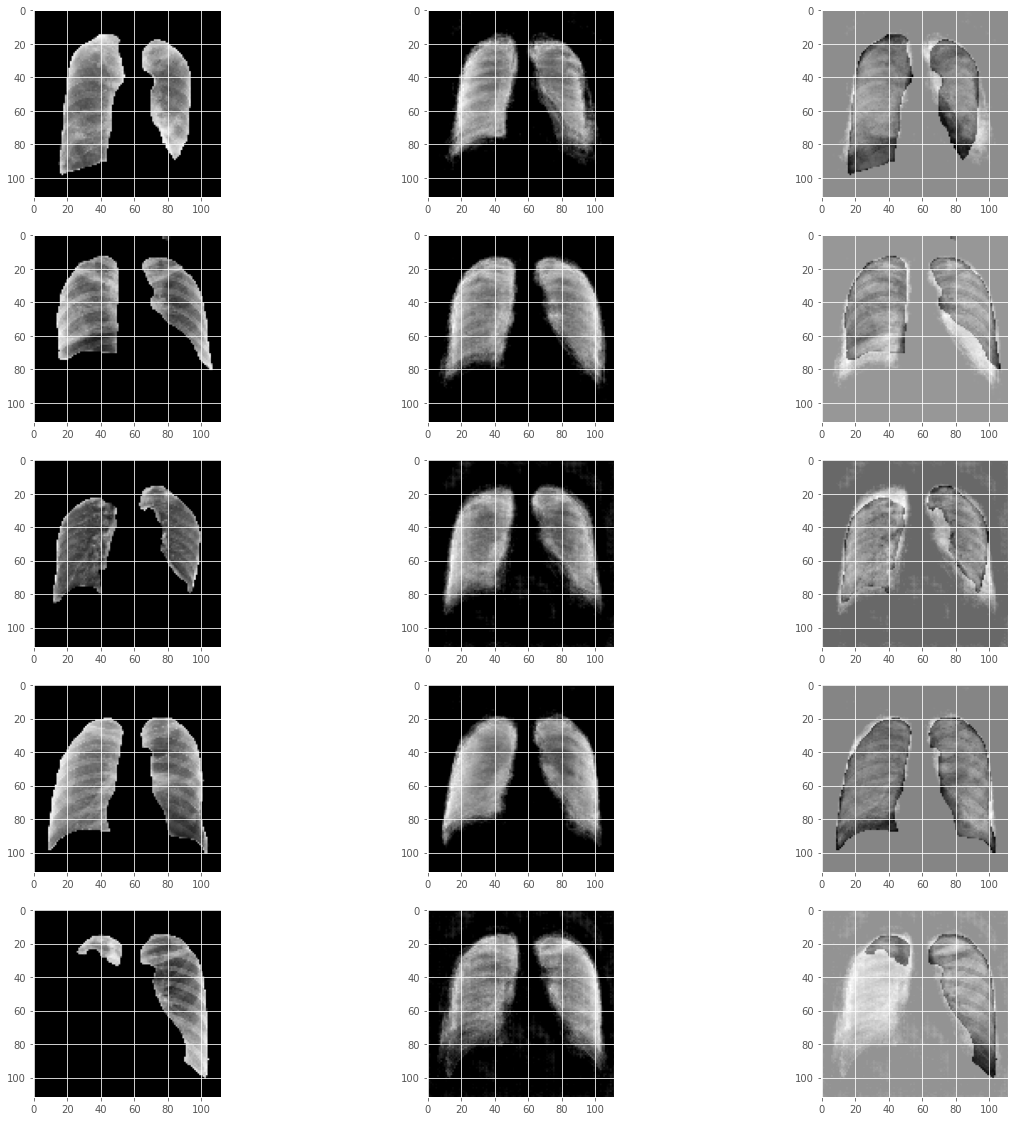

In [ ]:
view_data = [ltrue,lpred,lung_ab]
df = pd.read_csv('./csv/12.csv')
show_img(view_data,img_names[:5],df,figsize=(20,20))